In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import KNNImputer

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None) #forces all columns to be displayed
pd.set_option('display.max_rows', None) #forces all rows to be displayed

In [4]:
filepath = r'../data/data-reduced-train.csv'
data = pd.read_csv(filepath)

In [5]:
data.head()

,FIPS,State,County,% Adults with Diabetes,% Adults Reporting Currently Smoking,% Adults with Obesity,Food Environment Index,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,% Driving Deaths with Alcohol Involvement,% Uninsured,Dentist Rate,% with Annual Mammogram,% Vaccinated,% Completed High School,% Unemployed,% Children in Poverty,Income Ratio,% Children in Single-Parent Households,Social Association Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone to Work,% Long Commute - Drives Alone,% Food Insecure,% Limited Access to Healthy Foods,% Insufficient Sleep,% Uninsured Children,Other Primary Care Provider Rate,School Funding Adequacy,Gender Pay Gap,Median Household Income,% Household Income Required for Child Care Expenses,% Voter Turnout,% Census Participation,Traffic Volume,% Homeowners,% Households with Severe Cost Burden,% Households with Broadband Access,Population,% Less than 18 Years of Age,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
0,17027,Illinois,Clinton,8.7,16.7,34.8,9.0,25.8,63.809317,18.658612,14.285714,6.070879,32.51240,48.0,43.0,92.001064,2.951476,9.2,3.919867,16.250475,13.045960,8.8,9.181226,79.892449,39.5,7.0,3.741000,32.7,3.365561,86.69972,-3699.384446,0.735249,79612.0,21.156358,65.471311,73.9,14.192289,79.555648,7.830308,87.890706,36909.0,21.236013,18.662115,3.243111,0.403696,0.655667,0.083990,3.541142,91.007613,0.535157,47.787802,80.216266
1,42071,Pennsylvania,Lancaster,8.2,16.7,35.2,8.8,23.4,80.948635,17.168046,22.709163,11.306447,59.10580,53.0,60.0,86.957844,3.524487,11.9,3.779021,15.501977,13.799282,11.1,14.051126,74.112554,29.9,7.4,4.853843,36.8,11.306698,114.79819,5941.193063,0.755715,82434.0,30.232671,69.184565,75.9,104.296025,69.948992,11.788695,85.387678,556629.0,22.864601,19.735587,3.722587,0.474823,2.778152,0.114798,11.589407,80.193630,2.150077,50.747266,27.875490
2,46003,South Dakota,Aurora,8.2,17.0,38.8,7.8,23.1,3.349108,21.089477,60.000000,13.614801,0.00000,52.0,31.0,91.299304,1.877934,14.7,3.314294,15.384615,10.917031,4.7,5.333333,75.939306,25.5,6.0,16.918054,29.6,11.163522,145.19056,-1155.780000,0.783785,61013.0,20.880796,73.560209,55.1,5.316834,76.638177,7.763023,78.252612,2755.0,24.609800,21.125227,0.907441,2.903811,0.943739,0.000000,8.457350,85.880218,1.615576,48.566243,100.000000
3,46027,South Dakota,Clay,9.2,16.3,35.6,7.6,22.2,85.568250,22.062377,28.571429,13.246101,58.90052,50.0,60.0,93.400600,2.141792,17.1,5.000000,24.854142,13.861386,5.8,19.581749,71.909959,24.3,9.8,11.069810,28.4,7.773338,137.43455,-629.344700,0.743883,55263.0,27.781698,50.536585,65.7,86.059956,51.089365,16.624440,89.844904,15280.0,16.950262,12.624346,1.760471,4.011780,2.729058,0.065445,3.331152,86.302356,0.406533,50.425393,22.101958
4,13205,Georgia,Mitchell,15.9,22.8,42.2,6.8,34.5,59.917260,13.354151,16.666667,17.431074,14.20724,50.0,36.0,83.451327,3.968447,32.8,6.162685,53.611394,9.757911,9.7,17.456359,84.045812,39.4,15.0,7.944094,41.0,6.642538,61.56469,-17591.665000,0.691094,45296.0,25.927234,53.574417,51.7,20.260255,63.604240,15.178571,77.801615,21116.0,22.589506,18.407842,45.870430,0.672476,0.975564,0.066300,5.479257,46.126160,0.725704,49.720591,75.775684


In [6]:
target = '% Adults with Diabetes'
features = data.columns[4:]

Split the data:

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data[features], data[target],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

Check distribution of target variables

(array([ 63., 570., 765., 621., 294., 122.,  45.,  19.,  11.,   3.]),
 array([ 5.6 ,  7.26,  8.92, 10.58, 12.24, 13.9 , 15.56, 17.22, 18.88,
        20.54, 22.2 ]),
 <BarContainer object of 10 artists>)

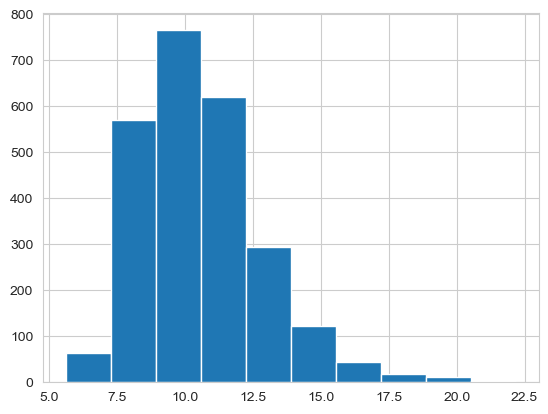

In [8]:
plt.hist(data[target])

Check the distribution of the target variable in the training and validation sets to ensure an even spread

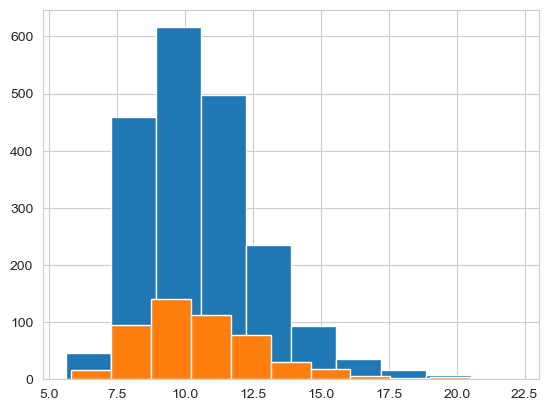

In [9]:
plt.hist(y_train)
plt.hist(y_val)

plt.show()

# Linear and XGB Regression Models

In [14]:
xgb = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                ('xgbreg', XGBRegressor())])

linear = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                   ('scale', StandardScaler()), #For comparing coefficient sizes
                    ('linreg', LinearRegression())])

xgb.fit(X_train, y_train)
linear.fit(X_train, y_train)

Pipeline(steps=[('impute', KNNImputer(n_neighbors=10)),
                ('scale', StandardScaler()), ('linreg', LinearRegression())])

Check the fit on the training data:

In [15]:
linear_train_preds = linear.predict(X_train)
xgb_train_preds = xgb.predict(X_train)

print('Linear RMSE on the training set:', root_mean_squared_error(y_train, linear_train_preds))
print('XGB RMSE on the training set:', root_mean_squared_error(y_train, xgb_train_preds))

Linear RMSE on the training set: 0.472038732165765
XGB RMSE on the training set: 0.016973048199400036


Check fit on the validation set:

In [16]:
linear_val_preds = linear.predict(X_val)
xgb_val_preds = xgb.predict(X_val)

print('Linear RMSE on the validation set:', root_mean_squared_error(y_val, linear_val_preds))
print('XGB RMSE on the validation set:', root_mean_squared_error(y_val, xgb_val_preds))

Linear RMSE on the validation set: 0.4969364285883717
XGB RMSE on the validation set: 0.5556831512282139


XGBoost might be slightly overfitting to its training set

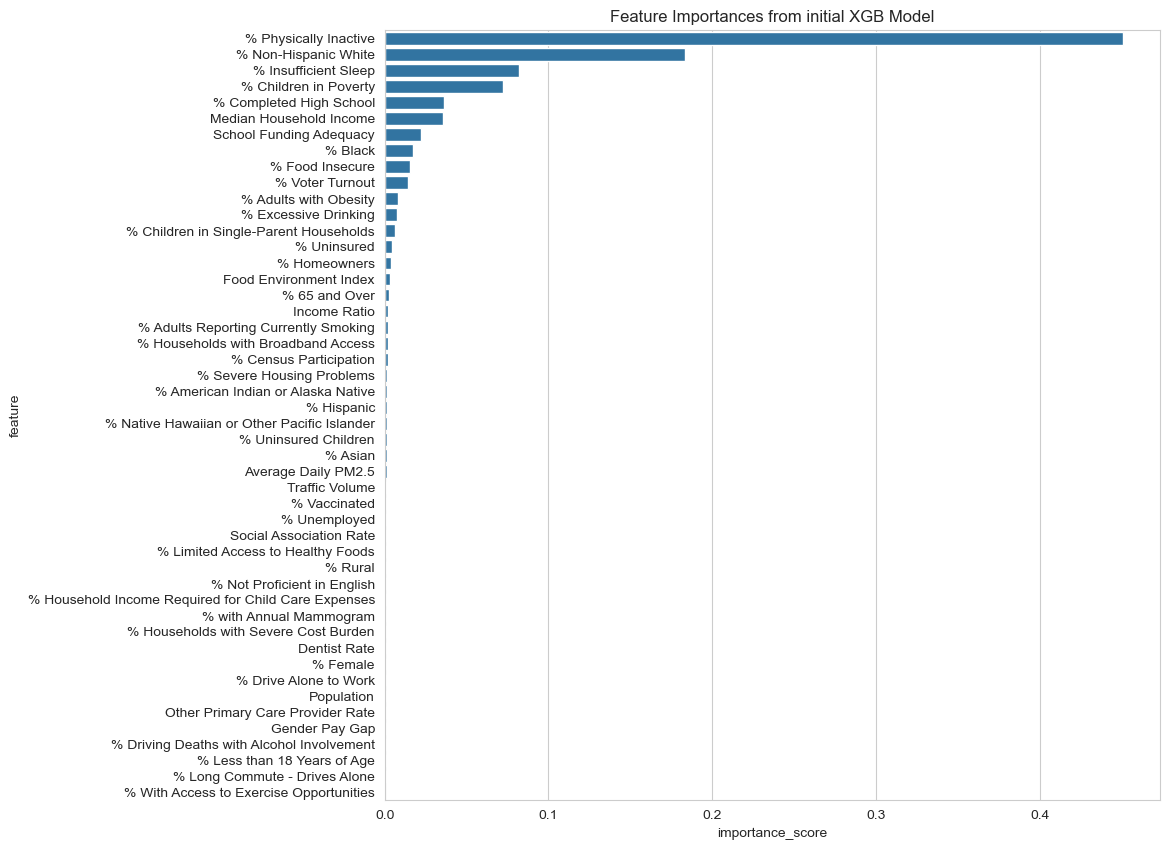

In [17]:
#data frame matching features with their importances computed from xgboost
xgb_importances = pd.DataFrame({'feature': features,
                               'importance_score': xgb['xgbreg'].feature_importances_})\
                                .sort_values(by='importance_score', ascending=False)

plt.figure(figsize=(10,10))
plt.title("Feature Importances from initial XGB Model")
sns.barplot(data=xgb_importances, y='feature', x='importance_score', orient='h')

plt.show()

Computation of coefficient sizes for each feature in the linear model

In [18]:
#data frame matching features with their coefficients from the linear model
coefficients = pd.DataFrame({'feature': features,
                             'coefficient': linear['linreg'].coef_}).sort_values(by='coefficient', ascending=False)

intercept = linear['linreg'].intercept_

print(intercept)

10.559203980099502


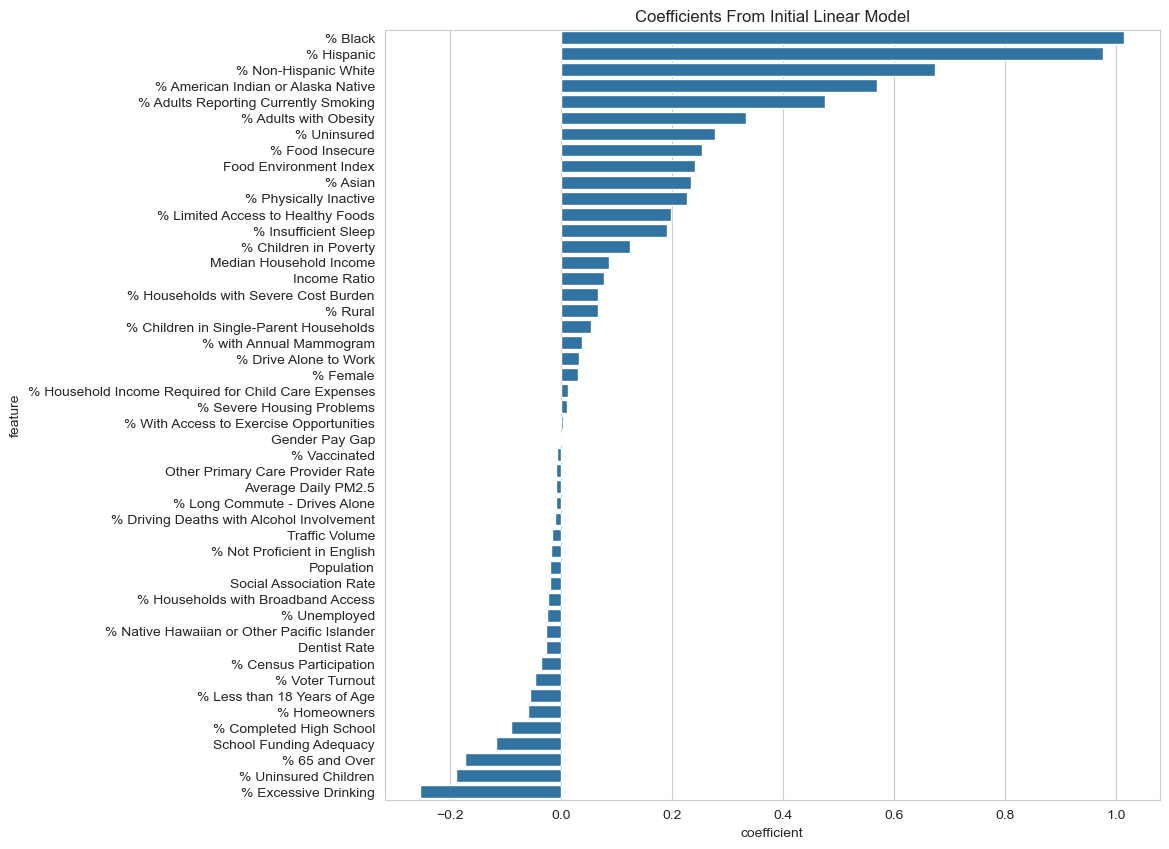

In [19]:
plt.figure(figsize=(10,10))
plt.title("Coefficients From Initial Linear Model")
sns.barplot(data=coefficients, orient='h', x='coefficient', y='feature')

plt.show()

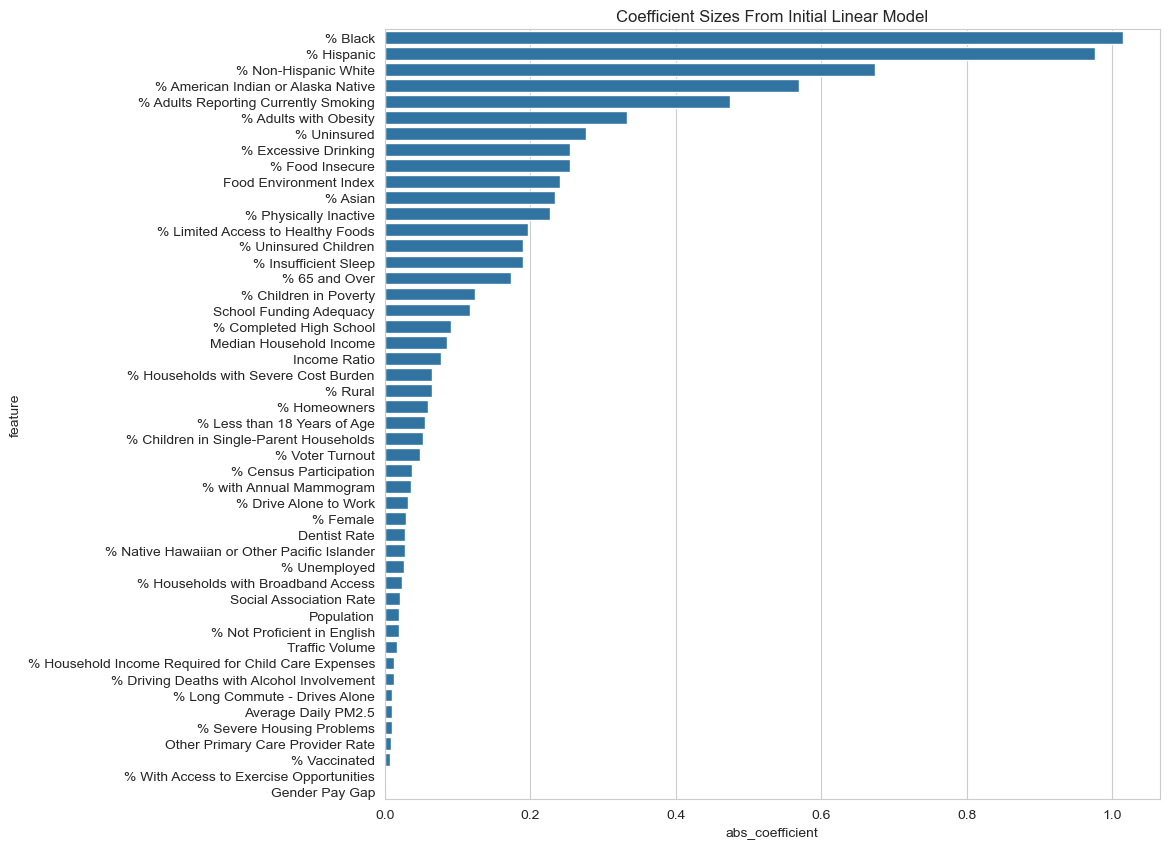

In [20]:
#data frame matching features with absolute values of their coefficients
abs_coefficients = pd.DataFrame({'feature': features,
                             'abs_coefficient': np.abs(linear['linreg'].coef_)})\
                                .sort_values(by='abs_coefficient', ascending=False)

plt.figure(figsize=(10,10))
plt.title("Coefficient Sizes From Initial Linear Model")
sns.barplot(data=abs_coefficients, orient='h', x='abs_coefficient', y='feature')

plt.show()

## Random Forest Model

In [21]:
forest_pipe = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                        ('rfr', RandomForestRegressor())])

forest_pipe.fit(X_train, y_train)
forest_train_preds = forest_pipe.predict(X_train)
forest_val_preds = forest_pipe.predict(X_val)

# Baseline model comparisons

## Mean model fitting
Every prediction is assumed to be the mean value of the training set

In [26]:
target_training_mean = np.mean(y_train)

mean_train_preds = target_training_mean*np.ones(y_train.shape)
mean_val_preds = target_training_mean*np.ones(y_val.shape)

## Random sampling model
Every value is randomly chosen from the training set

In [27]:
random_train_preds = np.random.choice(y_train, size=y_train.shape)
random_val_preds = np.random.choice(y_train, size=y_val.shape)

## Simple Linear Model on '% Adults with Obesity'

In [28]:
slr = Pipeline([('impute', KNNImputer(n_neighbors=10)),
                ('scale', StandardScaler()), #scaling shouldn't matter for rudimentary analysis, but is included here for consistency
                ('linreg', LinearRegression())])

slr.fit(X_train[['% Adults with Obesity']], y_train)

slr_train_preds = slr.predict(X_train[['% Adults with Obesity']])
slr_val_preds = slr.predict(X_val[['% Adults with Obesity']])

Prediction scores on the training set:

In [30]:
print('Mean Model RMSE on the training set:', root_mean_squared_error(y_train, mean_training_preds))
print('Random Sampling RMSE model on the training set:', root_mean_squared_error(y_train, random_training_preds))
print('Simple Linear model RMSE on the training set:', root_mean_squared_error(y_train, slr_training_preds))

print('Linear RMSE on the training set:', float(root_mean_squared_error(y_train, linear_train_preds)))
print('XGB RMSE on the training set:', float(root_mean_squared_error(y_train, xgb_train_preds)))
print('RFR RMSE on the training set:', float(root_mean_squared_error(y_train, forest_train_preds)))

Mean Model RMSE on the training set: 2.231842681376091
Random Sampling RMSE model on the training set: 3.119811513632998
Simple Linear model RMSE on the training set: 1.6409852985420361
Linear RMSE on the training set: 0.472038732165765
XGB RMSE on the training set: 0.016973048199400036
RFR RMSE on the training set: 0.20090426793779664


Prediction scores on the validation set:

In [31]:
print('Mean Model RMSE on the validation set:', root_mean_squared_error(y_val, mean_val_preds))
print('Random Sampling RMSE model on the validation set:', root_mean_squared_error(y_val, random_val_preds))
print('Simple Linear model RMSE on the validation set:', root_mean_squared_error(y_val, slr_val_preds))

print('Linear RMSE on the validation set:', float(root_mean_squared_error(y_val, linear_val_preds)))
print('XGB RMSE on the validation set:', float(root_mean_squared_error(y_val, xgb_val_preds)))
print('RFR RMSE on the validation set:', float(root_mean_squared_error(y_val, forest_val_preds)))

Mean Model RMSE on the validation set: 2.31191268895123
Random Sampling RMSE model on the validation set: 3.20943564153839
Simple Linear model RMSE on the validation set: 1.6401289727858297
Linear RMSE on the validation set: 0.4969364285883717
XGB RMSE on the validation set: 0.5556831512282139
RFR RMSE on the validation set: 0.5640937118119345
